In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F
import torch.nn as nn
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preapare data

In [3]:
batch_size = 64

### Data transform

In [4]:
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [34]:
train_dataset = MNIST(root="data",train=True,
                      download=True, transform=data_transforms)

test_dataset = MNIST(root="data",train=False,download=True,
                     transform=data_transforms)

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,
                          shuffle=False)

### Visualization

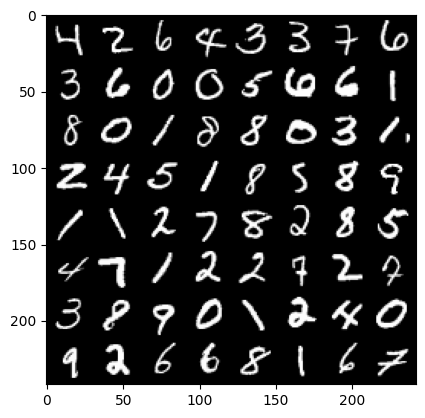

In [6]:
sample = iter(train_loader)
sample = next(sample)

images, labels = sample
classes = MNIST.classes
num_classes = len(classes)


n_rows = n_cols = 8

def show(imgs_grid):
    imgs_grid = imgs_grid.detach()
    imgs_grid = F.to_pil_image(imgs_grid)
    
    plt.imshow(np.asarray(imgs_grid))
    plt.show()

imgs_grid = torchvision.utils.make_grid(images)


show(imgs_grid)
        

## Model

In [7]:
seq_length = 28
input_size = 28
hidden_size = 128
num_layers = 2

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Size h0: D*num_layers, N, H_out
        # D = 1, N = batch_size, H_out = hidden_size
        
        h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size).to(device)
        
        # Size c0: D*num_layers, N, Hcell(hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        output, _ = self.lstm(x, (h0, c0))
        output = output[:, -1, :]
        
        out = self.fc(output)
        return out
        
        

## Training

### Hyperparams

In [21]:
epochs = 20
lr = 1e-3
plot_steps = 1
print_steps = 100


In [9]:
model = LSTMModel(input_size=input_size, hidden_size=hidden_size,
                  num_layers=num_layers, num_classes=num_classes).to(device)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

current_loss = 0
loss_his = []

In [22]:
n_total_steps = len(train_loader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, seq_length, input_size).to(device)
        labels = labels.to(device)
        
        
        # Forward
        output = model(images).to(device)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item()

        if (i + 1) % print_steps == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Step [{i+1}/{n_total_steps}]: Loss {loss.item():.4f}")
    if (epoch + 1)%plot_steps == 0:
      loss_his.append(current_loss / plot_steps)
      current_loss = 0
        
        

Epoch [1/20], Step [100/938]: Loss 0.0014
Epoch [1/20], Step [200/938]: Loss 0.0066
Epoch [1/20], Step [300/938]: Loss 0.0004
Epoch [1/20], Step [400/938]: Loss 0.0554
Epoch [1/20], Step [500/938]: Loss 0.0011
Epoch [1/20], Step [600/938]: Loss 0.0008
Epoch [1/20], Step [700/938]: Loss 0.0156
Epoch [1/20], Step [800/938]: Loss 0.0034
Epoch [1/20], Step [900/938]: Loss 0.0005
Epoch [2/20], Step [100/938]: Loss 0.0066
Epoch [2/20], Step [200/938]: Loss 0.0113
Epoch [2/20], Step [300/938]: Loss 0.0643
Epoch [2/20], Step [400/938]: Loss 0.0008
Epoch [2/20], Step [500/938]: Loss 0.0002
Epoch [2/20], Step [600/938]: Loss 0.0008
Epoch [2/20], Step [700/938]: Loss 0.0084
Epoch [2/20], Step [800/938]: Loss 0.0062
Epoch [2/20], Step [900/938]: Loss 0.0233
Epoch [3/20], Step [100/938]: Loss 0.0025
Epoch [3/20], Step [200/938]: Loss 0.0004
Epoch [3/20], Step [300/938]: Loss 0.0046
Epoch [3/20], Step [400/938]: Loss 0.0002
Epoch [3/20], Step [500/938]: Loss 0.0017
Epoch [3/20], Step [600/938]: Loss

## Evaluating

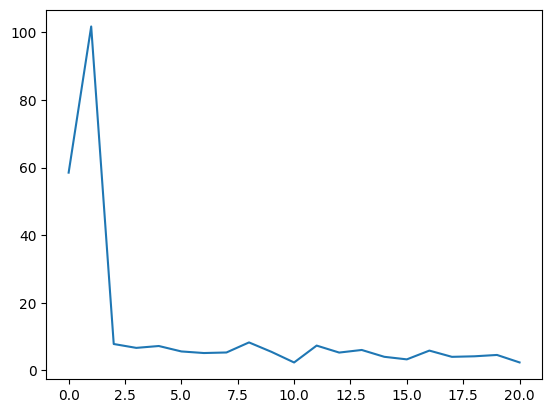

In [23]:
plt.plot(loss_his)
plt.show()

In [35]:

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.reshape(-1, seq_length, input_size).to(device)
    labels = labels.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    n_samples +=labels.size(0)
    n_correct += (predicted == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f"Acc : {acc} %")

Acc : 99.04 %
